In [1]:
import itertools
import math

try:
    from collections.abc import Generator, Sequence
except ImportError:
    from collections import Sequence, Generator

from typing import Protocol, TypeVar, Union, Generic, Any

import numpy as np
import torch

__all__ = ["TensorDataLoader", "LightDataLoader"]
# ----------------------------------- types ---------------------------------- #
_T_co = TypeVar("_T_co", covariant=True)

class _HasIterDunder(Protocol[_T_co]):
    def __iter__(self) -> _T_co: ...

class _SupportsLenAndGetitem(Protocol[_T_co]):
    def __len__(self) -> int: ...
    def __getitem__(self, __k: int, /) -> _T_co: ...


# ----------------------------- tensor dataloader ---------------------------- #

_TensorOrTuple = TypeVar("_TensorOrTuple", bound=Union[torch.Tensor, Sequence[torch.Tensor]])

class TensorDataLoader(Generic[_TensorOrTuple]):
    def __init__(
        self,
        data: _TensorOrTuple,
        batch_size: int = 1,
        shuffle: bool = False,
        memory_efficient: bool = False,
        seed: Union[int, torch.Generator, None] = None,
    ):
        """A very fast DataLoader for datasets that are fully loaded into memory as tensors.

        Args:
            data (Tensor | Sequence[Tensor]):
                either a single tensor with all samples stacked along the first dimension,
                or a tuple of tensors if each sample has more than one tensor.
                For example, if you have 500 samples of shape (32,32) and 500 labels of shape (10),
                you can pass a tuple of two tensors of the following shapes: `(samples[500, 32, 32], labels[500, 10])`.
            batch_size (int, optional): how many samples per batch to load (default: 1).
            shuffle (bool, optional): set to True to have the data reshuffled at every epoch (default: False).
            memory_efficient (bool, optional):
                enables memory efficient, but slightly slower dataloader.
                During shuffling before each epoch, this uses two times the memory that `data` uses.
                But when `memory_efficient` is enabled, no additional memory will be used (default: False).
            seed (int | torch.Generator | None, optional):
                seed for shuffling, set to None to let pytorch use a random seed.
                Can also be a torch.Generator, but make sure it is on the same device as `data`. Defaults to None.
        """

        self.data: _TensorOrTuple = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.memory_efficient = memory_efficient

        self._istensor = isinstance(self.data, torch.Tensor)
        self.device = self.data.device if isinstance(self.data, torch.Tensor) else self.data[0].device

        self.seed = seed
        if isinstance(self.seed, torch.Generator): self.generator = self.seed
        elif seed is not None: self.generator = torch.Generator(self.device).manual_seed(seed)
        else: self.generator = None

    def data_length(self):
        ref = self.data if self._istensor else self.data[0]
        return ref.size(0)

    def __len__(self):
        return math.ceil(self.data_length() / self.batch_size)

    def _fast_iter(self) -> Generator[_TensorOrTuple, None, None]:
        if self.shuffle:
            idxs = torch.randperm(self.data_length(), generator = self.generator, device = self.device)
            if self._istensor:
                self.data = torch.index_select(self.data, 0, idxs)
            else:
                self.data = [torch.index_select(i, 0, idxs) for i in self.data]

        if self._istensor:
            yield from self.data.split(self.batch_size)
        else:
            yield from zip(*(i.split(self.batch_size) for i in self.data))

    def _memory_efficient_iter(self) -> Generator[_TensorOrTuple, None, None]:
        if self.shuffle:
            idxs = torch.randperm(self.data_length(), generator = self.generator, device = self.device)

            for batch_indices in idxs.split(self.batch_size):
                if self._istensor:
                    yield self.data[batch_indices]
                else:
                    yield [i[batch_indices] for i in self.data]

    def __iter__(self) -> Generator[_TensorOrTuple, None, None]:
        if self.memory_efficient: return self._memory_efficient_iter()
        return self._fast_iter()

# ----------------------------- light dataloader ----------------------------- #
class _SupportsLenAndGetitems(Protocol[_T_co]):
    def __len__(self) -> int: ...
    def __getitems__(self, __k: Any) -> _T_co: ...

_SampleOrTuple = TypeVar("_SampleOrTuple", bound=Union[torch.Tensor, Any, Sequence[torch.Tensor], Sequence[Any]])

class LightDataLoader(Generic[_SampleOrTuple]):
    def __init__(
        self,
        data: Union[_SupportsLenAndGetitem[_SampleOrTuple], _SupportsLenAndGetitems[_SampleOrTuple]],
        batch_size: int = 1,
        shuffle: bool = False,
        seed: Union[int, np.random.Generator, None] = None,
    ):
        """A lightweight dataloader that collates `data`.

        Args:
            data (Sequence[Tensor | int | float | Any] | Sequence[Sequence[Tensor | int | float | Any]]):
                a sequence of samples. They must either be tensors or tuples of tensors,
                or be convertable to tensors with `torch.as_tensor`, so they can be python ints and floats.

                As in pytorch dataloader, `data` can also be an object with `__getitems__(self, idxs: tuple[int, ...])` method.
                It should be equivalent to `[data[i] for i in idxs]`, but can potentially implement
                paralellization.
            batch_size (int, optional): how many samples per batch to load (default: 1).
            shuffle (bool, optional): set to True to have the data reshuffled at every epoch (default: False).
            seed (int | np.random.Generator | None, optional):
                seed for shuffling, set to None to let numpy use a random seed.
                Can also be a numpy.random.Generator. Defaults to None.
        """
        self.data: _SupportsLenAndGetitem[_SampleOrTuple] = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        self._use_getitems = hasattr(self.data, "__getitems__")

        self.seed = seed
        if isinstance(self.seed, np.random.Generator): self.generator = self.seed
        else: self.generator = np.random.default_rng(seed)

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __iter__(self) -> Generator[_SampleOrTuple, None, None]:

        if self.shuffle: indices = self.generator.permutation(len(self.data))
        else: indices = range(len(self.data))

        for batch_indices in itertools.batched(indices, self.batch_size):
            if self._use_getitems: uncollated_batch = self.data.__getitems__(batch_indices)
            else: uncollated_batch = [self.data[i] for i in batch_indices]
            if isinstance(uncollated_batch[0], torch.Tensor):
                yield torch.stack(uncollated_batch)
            else:
                collated = list(zip(*uncollated_batch))
                yield [torch.stack(i) if isinstance(i[0], torch.Tensor) else torch.as_tensor(i) for i in collated]



In [2]:
from time import perf_counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# download and pre-load CIFAR10 to memory
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
loader = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32)])
cifar = list(CIFAR10('cifar10', transform = loader, download=True))

time_per_batch_size = {}

Files already downloaded and verified


In [3]:
images = torch.stack([i[0] for i in cifar])
labels = torch.tensor([i[1] for i in cifar])

# z-normalize
images -= images.mean()
images /= images.std()

images.shape, labels.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000]))

# torch.utils.data.TensorDataset with torch.utils.data.DataLoader

In [4]:
from torch.utils.data import TensorDataset, DataLoader
tensor_dataset = TensorDataset(images, labels)

In [5]:
time_per_batch_size['pytorch DataLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  pytorch_dataloader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in pytorch_dataloader: pass
  time_per_batch_size['pytorch DataLoader'].append(perf_counter() - start)

print(time_per_batch_size['pytorch DataLoader'])

100%|██████████| 128/128 [01:31<00:00,  1.41it/s]

[4.23110488400016, 1.3973519460005264, 0.7652505969999766, 0.6843709140002829, 0.6357092399994144, 0.6219725640003162, 0.6027260579994618, 0.6014764659994398, 0.602238927000144, 0.5881932090005648, 0.5892765349999536, 0.5857951319994754, 0.5973112319998108, 0.5892992039998717, 0.5631797070000175, 0.5864598600001045, 0.5572584060000736, 0.5614175709997653, 0.8042122670003664, 0.8403348199999527, 0.8518317259995456, 0.676027678000537, 0.5894191330007743, 0.5960510349996184, 0.7692389009998806, 0.5890802949998033, 0.5903943450002771, 0.5702834090006945, 0.5798644870001226, 0.5663680939996993, 0.5889931140000044, 0.5850818039998558, 0.5890873150001426, 0.8038386190000892, 0.5905443830006334, 0.5824116630001299, 0.5936105589998988, 0.662903481000285, 0.8689259080001648, 0.8440790160002507, 0.8523167620005552, 0.5658257160002904, 0.5792307540004913, 0.5716501549995883, 0.7963717759994324, 0.612964416000068, 0.5614323310001055, 0.6062201920003645, 0.5911191309996866, 0.7762094350000552, 0.579

In [6]:
time_per_batch_size['pytorch DataLoader with pin_memory'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  pytorch_pin_dataloader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)

  start = perf_counter()
  for batch in pytorch_pin_dataloader: pass
  time_per_batch_size['pytorch DataLoader with pin_memory'].append(perf_counter() - start)

print(time_per_batch_size['pytorch DataLoader with pin_memory'])

100%|██████████| 128/128 [01:31<00:00,  1.40it/s]

[4.639947767999729, 0.8963535909997518, 0.766347800999938, 0.7463011440004266, 0.6353015849999792, 0.6581979700004013, 0.6308297650002714, 0.6573800070000289, 0.6260385710002083, 0.6052900909999153, 0.5971961300001567, 0.6113126050004212, 0.5928286540001864, 0.597436091000418, 0.5741246210000099, 0.8114867310005138, 0.8429156680003871, 0.8837350069998138, 0.7433194800005367, 0.5856310809995193, 0.5613680540000132, 0.5958805700001903, 0.588444702999368, 0.5902775449994806, 0.5977754510004161, 0.5809554159995969, 0.5806952600005388, 0.5679981399998724, 0.7751476280000134, 0.5968130490000476, 0.6302756499999305, 0.6009035180004503, 0.5809355320006944, 0.6178645580002922, 0.5851222339997548, 0.8591821119998713, 0.8394704890006324, 0.896863797000151, 0.865471131999584, 0.5892691879998893, 0.5690144700001838, 0.6115194609992614, 0.5996879370004535, 0.5828758050001852, 0.5888802320005198, 0.5828287350004757, 0.7733091529999001, 0.574522060000163, 0.5939398249993246, 0.5874278189994584, 0.6095

# LightDataLoader

In [ ]:
# 3.12+ only

# TensorLoader

In [10]:
!pip install tensorloader
from tensorloader import TensorLoader

time_per_batch_size['TensorLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  tensor_dataloader = TensorLoader((images, labels), batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in tensor_dataloader: pass
  time_per_batch_size['TensorLoader'].append(perf_counter() - start)

print(time_per_batch_size['TensorLoader'])

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensorloader: filename=tensorloader-0.1.0-py3-none-any.whl size=7979 sha256=5539f5f14ced38dd58a6660113ae964211b39f02a98a2a0af3f6b1c458cfa53e
  Stored in directory: /root/.cache/pip/wheels/71/23/67/f2389da19c6985d0612ad39b63adb667b2dc88a222f9d16c74
Successfully built tensorloader


100%|██████████| 128/128 [01:07<00:00,  1.90it/s]

[0.8884677699998065, 0.5395070320000741, 0.5397339809996993, 0.4908146459993077, 0.48520414700033143, 0.49921379599982174, 0.4774223570002505, 0.48719419700046274, 0.4929618650003249, 0.5138566619998528, 0.4760903200003668, 0.48435973599953286, 0.4793027549994804, 0.4840767739997318, 0.4794808970000304, 0.48104691300068225, 0.48441698100032227, 0.5502460400002747, 0.6669444019998991, 0.7128817940001682, 0.6784721059993899, 0.6481420189993514, 0.4885156210002606, 0.4736510129996532, 0.47900206799931766, 0.47774638299961225, 0.47128774000066187, 0.4905519829999321, 0.48074939000071026, 0.48906164999971224, 0.47361866799928976, 0.48603055700004916, 0.48033370999928593, 0.48659867300011683, 0.5114072850001321, 0.4864870459996382, 0.472253343000375, 0.4848298540000542, 0.47229658600008406, 0.4883169069998985, 0.48002381599962973, 0.47652600099991105, 0.5659892739995485, 0.6687309369999639, 0.6710041039996213, 0.7001045449997036, 0.6317335009998715, 0.4738180660006037, 0.4817472849999831, 0.

# TensorDataLoader

In [7]:
time_per_batch_size['TensorDataLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  tensor_dataloader = TensorDataLoader((images, labels), batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in tensor_dataloader: pass
  time_per_batch_size['TensorDataLoader'].append(perf_counter() - start)

print(time_per_batch_size['TensorDataLoader'])

100%|██████████| 128/128 [01:02<00:00,  2.05it/s]

[1.362549198999659, 0.9619350049997593, 0.46332094900026277, 0.46491363200038904, 0.4626243479997356, 0.46241112100051396, 0.4578948620001029, 0.46606324200001836, 0.46264690600037284, 0.48116178599957493, 0.45787620800001605, 0.47316222800054675, 0.47332676899986836, 0.4659871089997978, 0.4894162820000929, 0.476663696000287, 0.4620111109998106, 0.44546619599987025, 0.4518352400000367, 0.4475901370005886, 0.46620213499954843, 0.45610206499986816, 0.4453575079996881, 0.5358226919997833, 0.6317355940000198, 0.5868298280001909, 0.6350391100004344, 0.5685910169995623, 0.45207033199949365, 0.4416815900003712, 0.45748320300026535, 0.4489594140004556, 0.44376800099962566, 0.46046902799935197, 0.4459288750003907, 0.4667527149995294, 0.4417223450000165, 0.45288248999986536, 0.4490155280000181, 0.4460976959999243, 0.4472129940004379, 0.44699325100009446, 0.4567631289992278, 0.4383640229998491, 0.4640206659996693, 0.44177977700019255, 0.4583187119997092, 0.44380762499986304, 0.45823875199948816, 

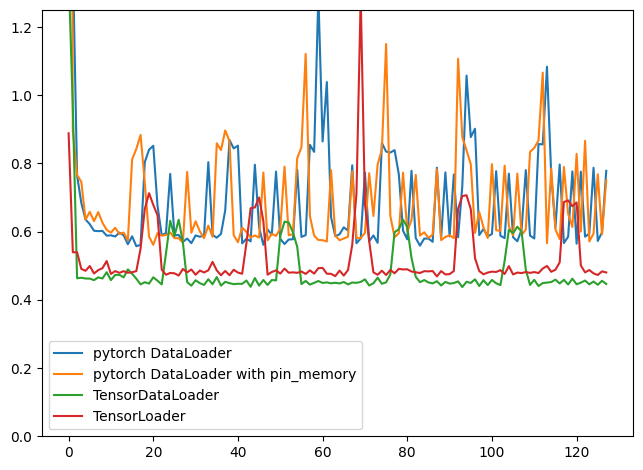

In [14]:
for key, vals in time_per_batch_size.items():
  plt.plot(vals, label = key)

plt.tight_layout()
plt.legend()
plt.ylim(0, 1.25)
plt.show()